# Dogs Vs Cats Classification using Tensorflow and Keras with Resnet50 Transfer Learning + Fine Tuning

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import applications, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import preprocess_input

## Define constants

In [3]:
# dimensions of our images
img_width, img_height = 224,224 # width and height should be no smaller than 197. 224 default values

PATH = 'data/dogscats_small/'
train_data_dir = f'{PATH}train/'
validation_data_dir = f'{PATH}validation/'
test_data_dir = f'{PATH}test/'
epochs = 10
batch_size = 64

In [4]:
# value stored in /users/<user>/keras/.keras.json file
# "channels_last" for tensorflow

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

## Helper functions

In [5]:
# ensure the child directories are non-empty and contain jpg files
def rand_img_from_child_dirs(dir_path):
    
    dirs =  [directory for directory in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path,directory)) 
             and not directory.startswith('.')]
    random_dir = np.random.choice(dirs)
    random_dir_path = os.path.join(dir_path,random_dir)
    files =  [file for file in os.listdir(random_dir_path) if file.endswith('.jpg')]
    random_img = np.random.choice(files)

    return os.path.join(random_dir_path,random_img)

In [6]:
def plot_training_history(log):
    acc = log.history['acc']
    val_acc = log.history['val_acc']
    loss = log.history['loss']
    val_loss = log.history['val_loss']

    epoch_range = range(len(acc))

    plt.plot(epoch_range, acc, 'b', label='Training acc')
    plt.plot(epoch_range, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epoch_range, loss, 'b', label='Training loss')
    plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [18]:
def print_layer_trainable(model):
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [29]:
def model_predict(data_dir, model):
    probs = []
    for fn in os.listdir(data_dir):
        img = load_img(data_dir+fn, target_size=(img_width,img_height))
        x = img_to_array(img)
        x = preprocess_input(x)
        x = np.expand_dims(x, axis=0)
        
        prob = np.asscalar(np.squeeze(model.predict(x)))
        probs.append(prob)

    return np.array(probs)

## Transfer Learning

### Prepare Training Data

In [19]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [20]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Build pre-trained model (ResNet50)

In [10]:
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

In [11]:
new_model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers: layer.trainable = False
new_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
%%time
training_log = new_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    workers=4,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/10
31/31 [==============================] - 29s 934ms/step - loss: 1.6514 - acc: 0.8018 - val_loss: 0.0487 - val_acc: 0.9805
Epoch 2/10
31/31 [==============================] - 23s 730ms/step - loss: 0.1621 - acc: 0.9420 - val_loss: 0.0420 - val_acc: 0.9857
Epoch 3/10
31/31 [==============================] - 23s 732ms/step - loss: 0.1357 - acc: 0.9517 - val_loss: 0.0443 - val_acc: 0.9870
Epoch 4/10
31/31 [==============================] - 23s 728ms/step - loss: 0.1535 - acc: 0.9526 - val_loss: 0.1098 - val_acc: 0.9661
Epoch 5/10
31/31 [==============================] - 23s 742ms/step - loss: 0.1336 - acc: 0.9567 - val_loss: 0.0569 - val_acc: 0.9805
Epoch 6/10
31/31 [==============================] - 22s 717ms/step - loss: 0.0697 - acc: 0.9748 - val_loss: 0.0526 - val_acc: 0.9818
Epoch 7/10
31/31 [==============================] - 23s 741ms/step - loss: 0.0855 - acc: 0.9793 - val_loss: 0.0643 - val_acc: 0.9831
Epoch 8/10
31/31 [==============================] - 23s 749ms/step - 

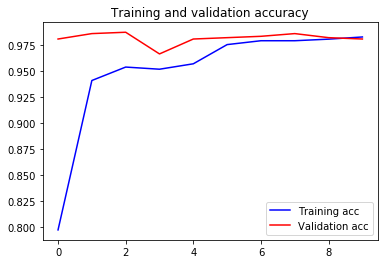

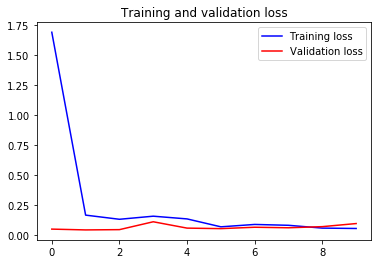

In [13]:
plot_training_history(training_log)

### Save model

#### Save as full model

In [14]:
os.makedirs(f'{PATH}models/', exist_ok=True)

In [15]:
new_model.save(f'{PATH}/models/rs50_bottleneck_fc_model.h5')

#### Save as architecture definition (json) + weights value

In [16]:
model_json = new_model.to_json()

with open(f'{PATH}/models/rs50_bottleneck_fc_arch.json', 'w') as json_file:
    json_file.write(model_json)
    
new_model.save_weights(f'{PATH}/models/rs50_bottleneck_fc_weights.h5')

### Load model to predict test data

In [17]:
# both options should return the same model but we may want to 
# change the weights using those obtained from training
load_from_model_file = True

if load_from_model_file:
    test_model = load_model(f'{PATH}/models/rs50_bottleneck_fc_model.h5')
else:
    json_file = open(f'{PATH}/models/rs50_bottleneck_fc_arch.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    test_model = model_from_json(loaded_model_json)

    test_model.load_weights(f'{PATH}/models/rs50_bottleneck_fc_weights.h5')

### Predict on single image

data/dogscats_small/validation/cats/cat.1038.jpg


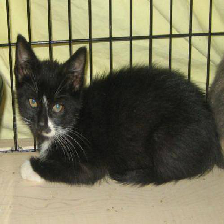

In [18]:
rand_img_path = rand_img_from_child_dirs(validation_data_dir)
rand_img = image.load_img(rand_img_path, target_size=(img_width, img_height))    
rand_dog_cat = 'dog' if 'validation/dogs' in rand_img_path else 'cat'

print(rand_img_path)
rand_img

In [19]:
x_test = image.img_to_array(rand_img)
x_test = preprocess_input(x_test)
x_test = np.expand_dims(x_test, axis=0) # increase dimension so that can be fed into model

In [20]:
prob = np.asscalar(np.squeeze(test_model.predict(x_test)))
prob

4.483455165286976e-13

In [21]:
res = 'dog' if prob>=0.5 else 'cat'
pct = round(prob*100,2)
if res is 'cat':
    pct = 100 - pct 

print('The model is ' + str(pct) + '% sure this is a ' + res)

The model is 100.0% sure this is a cat


### Predict on batch of test images

Unlike validation data, these are never seen or tested before

In [32]:
dog_test_dir = f"{test_data_dir}dogs/"
cat_test_dir = f"{test_data_dir}cats/"

In [25]:
pred_dogs = model_predict(dog_test_dir, test_model)

In [26]:
pred_cats = model_predict(cat_test_dir, test_model)

In [27]:
cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100
overall_acc = (cat_acc+dog_acc)/2.0

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')
print(f'Overall Accuracy: {overall_acc:.2f}%')

Cat Prediction Accuracy: 99.70%
Dog Prediction Accuracy: 95.90%
Overall Accuracy: 97.80%


## Fine-tuning

In [8]:
finetune_model = load_model(f'{PATH}/models/rs50_bottleneck_fc_model.h5')
finetune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [9]:
print_layer_trainable(finetune_model)

True:	input_1
False:	conv1
False:	bn_conv1
False:	activation
False:	max_pooling2d
False:	res2a_branch2a
False:	bn2a_branch2a
False:	activation_1
False:	res2a_branch2b
False:	bn2a_branch2b
False:	activation_2
False:	res2a_branch2c
False:	res2a_branch1
False:	bn2a_branch2c
False:	bn2a_branch1
False:	add
False:	activation_3
False:	res2b_branch2a
False:	bn2b_branch2a
False:	activation_4
False:	res2b_branch2b
False:	bn2b_branch2b
False:	activation_5
False:	res2b_branch2c
False:	bn2b_branch2c
False:	add_1
False:	activation_6
False:	res2c_branch2a
False:	bn2c_branch2a
False:	activation_7
False:	res2c_branch2b
False:	bn2c_branch2b
False:	activation_8
False:	res2c_branch2c
False:	bn2c_branch2c
False:	add_2
False:	activation_9
False:	res3a_branch2a
False:	bn3a_branch2a
False:	activation_10
False:	res3a_branch2b
False:	bn3a_branch2b
False:	activation_11
False:	res3a_branch2c
False:	res3a_branch1
False:	bn3a_branch2c
False:	bn3a_branch1
False:	add_3
False:	activation_12
False:	res3b_branch2a
False

In [21]:
len(finetune_model.layers)

177

In [22]:
split_at = 141
for layer in finetune_model.layers[:split_at]: layer.trainable = False
for layer in finetune_model.layers[split_at:]: layer.trainable = True

In [23]:
print_layer_trainable(finetune_model)

False:	input_1
False:	conv1
False:	bn_conv1
False:	activation
False:	max_pooling2d
False:	res2a_branch2a
False:	bn2a_branch2a
False:	activation_1
False:	res2a_branch2b
False:	bn2a_branch2b
False:	activation_2
False:	res2a_branch2c
False:	res2a_branch1
False:	bn2a_branch2c
False:	bn2a_branch1
False:	add
False:	activation_3
False:	res2b_branch2a
False:	bn2b_branch2a
False:	activation_4
False:	res2b_branch2b
False:	bn2b_branch2b
False:	activation_5
False:	res2b_branch2c
False:	bn2b_branch2c
False:	add_1
False:	activation_6
False:	res2c_branch2a
False:	bn2c_branch2a
False:	activation_7
False:	res2c_branch2b
False:	bn2c_branch2b
False:	activation_8
False:	res2c_branch2c
False:	bn2c_branch2c
False:	add_2
False:	activation_9
False:	res3a_branch2a
False:	bn3a_branch2a
False:	activation_10
False:	res3a_branch2b
False:	bn3a_branch2b
False:	activation_11
False:	res3a_branch2c
False:	res3a_branch1
False:	bn3a_branch2c
False:	bn3a_branch1
False:	add_3
False:	activation_12
False:	res3b_branch2a
Fals

In [24]:
#optimizer_fine = optimizers.Adam(lr=1e-7)
optimizer_fine = optimizers.RMSprop(lr=1e-7)
#optimizer_fine = optimizers.SGD(lr=1e-6, momentum=0.9)

In [25]:
# compile must be called after the trainable are set
finetune_model.compile(optimizer=optimizer_fine, loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
%%time
finetune_training_log = finetune_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=epochs,
    workers=4,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // batch_size)

Epoch 1/10
31/31 [==============================] - 37s 1s/step - loss: 0.0244 - acc: 0.9899 - val_loss: 0.0823 - val_acc: 0.9805
Epoch 2/10
31/31 [==============================] - 27s 860ms/step - loss: 0.0135 - acc: 0.9945 - val_loss: 0.0760 - val_acc: 0.9818
Epoch 3/10
31/31 [==============================] - 27s 857ms/step - loss: 0.0298 - acc: 0.9916 - val_loss: 0.0723 - val_acc: 0.9818
Epoch 4/10
31/31 [==============================] - 27s 861ms/step - loss: 0.0166 - acc: 0.9945 - val_loss: 0.0695 - val_acc: 0.9818
Epoch 5/10
31/31 [==============================] - 27s 860ms/step - loss: 0.0177 - acc: 0.9939 - val_loss: 0.0676 - val_acc: 0.9818
Epoch 6/10
31/31 [==============================] - 27s 861ms/step - loss: 0.0261 - acc: 0.9900 - val_loss: 0.0668 - val_acc: 0.9818
Epoch 7/10
31/31 [==============================] - 27s 861ms/step - loss: 0.0146 - acc: 0.9934 - val_loss: 0.0656 - val_acc: 0.9818
Epoch 8/10
31/31 [==============================] - 27s 860ms/step - los

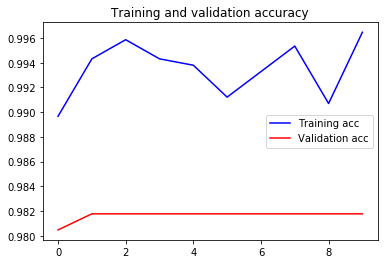

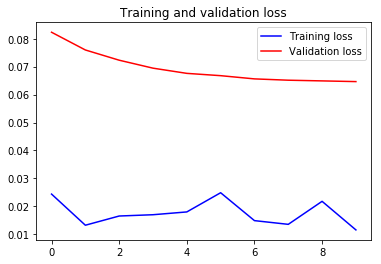

In [27]:
plot_training_history(finetune_training_log)

In [33]:
pred_dogs = model_predict(dog_test_dir, finetune_model)
pred_cats = model_predict(cat_test_dir, finetune_model)

In [34]:
cat_acc = len(pred_cats[pred_cats<0.5])/len(pred_cats) * 100
dog_acc = len(pred_dogs[pred_dogs>=0.5])/len(pred_dogs) * 100
overall_acc = (cat_acc+dog_acc)/2.0

print(f'Cat Prediction Accuracy: {cat_acc:.2f}%\nDog Prediction Accuracy: {dog_acc:.2f}%')
print(f'Overall Accuracy: {overall_acc:.2f}%')

Cat Prediction Accuracy: 99.40%
Dog Prediction Accuracy: 97.70%
Overall Accuracy: 98.55%


Before Tuning:

Run1
- Cat Prediction Accuracy: 97.30%
- Dog Prediction Accuracy: 99.40%
- Overall Accuracy : 98.35%

Run2
- Cat Prediction Accuracy: 99.70%
- Dog Prediction Accuracy: 95.90%
- Overall Accuracy: 97.80%

After Tuning:
    
With Adam(lr=1e-7)
- Cat Prediction Accuracy: 99.30%
- Dog Prediction Accuracy: 97.90%
- Overall Accuracy: 98.60%

With RMSprop(lr=1e-7)
- Cat Prediction Accuracy: 99.40%
- Dog Prediction Accuracy: 97.70%
- Overall Accuracy: 98.55%